In [63]:
#nokで
import pandas as pd
import numpy as np
import unicodedata
import sys
import datetime
import time
import MeCab
import collections
import mojimoji
import numpy as np
from pprint import pprint
from gensim import corpora
from gensim import models

from pprint import pprint
from scipy import spatial

import fasttext 
import fasttext.util
import re

from sklearn.preprocessing import OneHotEncoder



def is_japanise(str):
    import unicodedata
    
    for ch in str:
        name = unicodedata.name(ch)
        
        if'CJK UNIFIED'in name or'HIRAGANA'in name or'KATAKANA'in name or'BLACK'in name or 'DIGIT' in name or 'SQUARE' in name:
            return True
        else:
            return False
#日本語が混じっている単語のリスト作成
def wakatis(Str):
    
    stop_words= [',','｡','.','右','左','*','(',')','委任','/',':','。','、',',','.','+','→']
    import MeCab
    tagger = MeCab.Tagger(r"-d /var/lib/mecab/dic/ipadic-utf8/ -u dic/MANBYO_201907_Dic-utf8.dic -Owakati")              
    result = tagger.parse(Str).split()
    words = []
    stop_words = stop_words
    for word in result:
        if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None): # 数字が含まれるものは除外
            continue
        if word in stop_words: # ストップワードに含まれるものは除外
            continue
        if len(word) < 1: #  1文字、0文字（空文字）は除外
            continue
        words.append(word)
    return words

def wakati(Str):
    import MeCab
    
    stop_words=  [',','｡','.','右','左','*','(',')','委任',':','。','、',',','.','+']
    tagger = MeCab.Tagger(r"-d /var/lib/mecab/dic/ipadic-utf8/ -u dic/MANBYO_201907_Dic-utf8.dic -Owakati")              
    result = tagger.parse(Str).split()
    words = []
    stop_words = stop_words
    for word in result:
        if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None): # 数字が含まれるものは除外
            continue
        if word in stop_words: # ストップワードに含まれるものは除外
            continue
        if len(word) < 1: #  1文字、0文字（空文字）は除外
            continue
        words.append(word)
    words = ' '.join(words)
    return words

def colchoice2(df,word1,word2=None):
    if word2==None:
        word2=word1
    ss = [item for item in df.columns if item.find(word1)!= -1]
    sss = [item for item in ss if item.find(word2)!= -1]
    bb = " ".join([str(_) for _ in sss])
    return bb

In [64]:
def meishi(text):
    
    
    stop_words= [',','｡','.','右','左','*','(',')','委任',':','。','、',',','.','+']

    mecab = MeCab.Tagger(r"-d /var/lib/mecab/dic/ipadic-utf8/ -u dic/MANBYO_201907_Dic-utf8.dic")
    result = mecab.parse(text)
    lines = result.split('\n')
    nounAndVerb = []#「名詞」と「動詞」を格納するリスト
    for line in lines:
        feature = line.split('\t')
        if len(feature) == 2: #'EOS'と''を省く
            info = feature[1].split(',')
            hinshi = info[0]
            if hinshi in ('名詞', '動詞'):
                nounAndVerb.append(feature[0])
    words = []
    for word in nounAndVerb:
        if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None): # 数字が含まれるものは除外
            continue
        if word in stop_words: # ストップワードに含まれるものは除外
            continue
        if len(word) < 1:#  1文字、0文字（空文字）は除外
            continue
        words.append(word)
    return(words)
    
def meishi2(text):
    stop_words= [',','｡','.','右','左','*','(',')','委任',':','。','、',',','.','+']
    
    words = meishi(text)
    words = ' '.join(words)
    return(words)
    

In [65]:
#各doc2vecのモデル作成のための準備
def vec_test(PATH):
    import pandas as pd
    import datetime
    from sklearn.preprocessing import OneHotEncoder


    df=pd.read_csv(PATH,encoding='cp932')  
    df=df.rename(columns={'受付':'accept','年齢':'age','性':'sex','部位':'position','方法':'method','臨床診断':'diagnosis','依頼目的':'purpose','依頼科':'section'})
    pr=colchoice2(df,'実施','室')
    df=df.rename(columns={pr:'room'})
    bo=colchoice2(df,'予約')
    df=df.rename(columns={bo:'book'})
    st=colchoice2(df,'開始')
    df=df.rename(columns={st:'start'})
    en=colchoice2(df,'終了')
    df=df.rename(columns={en:'end'})
    
    delete =[]
    for i in df.columns.values:#日本語,記号のあるcolumnsは除外リストへ
        if is_japanise(i)==True:
            delete.append(i)
    df = df.drop(columns = delete)
    #空白を半角へ
    df['purpose'] = df['purpose'].replace([' ',' '], ' ')
    
    df['diagnosis'] = df['diagnosis'].map(str)
    df['purpose'] = df['purpose'].map(str)
    
    #def mojikana(a):
    #    a =  mojimoji.zen_to_han(a, kana=False)
    #    return a
        
    df['diagnosis'] = df['diagnosis'].map(mojimoji.zen_to_han)
    df['purpose'] = df['purpose'].map(mojimoji.zen_to_han)
    #df['diagnosis']=df['diagnosis'].str.replace(' ', '')
    #df['purpose']=df['purpose'].str.replace(' ', '')
    #df['purpose']=df['purpose'].str.replace('　', '')
    
    #df['diagnosis']=df['diagnosis'].str.upper()
    #df['purpose']=df['purpose'].str.upper()
    
    
    
    
    df_vectest=df.loc[:,['position','diagnosis','purpose']]
    
    
    df_vectest['position_words']=df_vectest['position'].map(meishi2)
    df_vectest['diagnosis_words']=df_vectest['diagnosis'].map(meishi2)
    #df_vectest['vec_list']=df_vectest['purpose'].map(wakatis)
    df_vectest['wakachi']=df_vectest['purpose'].map(wakati)
    df_vectest['meishi2']=df_vectest['purpose'].map(meishi2)
    #df_vectest['meishi_list']=df_vectest['purpose'].map(meishi)
    
    #df_vectest['fast_model']=(df_vectest['position_words'] + ' ' + df_vectest['diagnosis_words'] + ' ' + df_vectest['meishi2'])
    df_vectest['fast_model']=(df_vectest['position_words'] + ' ' + df_vectest['diagnosis_words'] + ' ' + df_vectest['meishi2'])
    
    df_vectest['fast_model']=df_vectest['fast_model'].str.lower()
    #df_vectest['purpose']=df_vectest['purpose'].str.lower()
    
    #df_vectest['fast_model'] = df_vectest['fast_model'].map(mojimoji.zen_to_han)
    #df_vectest['purpose'] = df_vectest['purpose'].map(mojimoji.zen_to_han)
    
    
    
    #print(len(vectest))
    
    #df_vectest=df_vectest[df_vectest['meishi'].isnull==False]
    #print(len(df_vectest))
    

    
    return df_vectest

In [66]:
a='SRS以前と比べてgo変化はBPASSどうでしょうか。p/o usフォローも3回お願いﾌｫﾛｰ:脳出血悪性黒色腫'
b='足及び足指'

In [7]:
print(a)

SRS以前と比べてgo変化はBPASSどうでしょうか。p/o usフォローも3回お願いﾌｫﾛｰ:脳出血悪性黒色腫


In [8]:
wakati(a)

'SRS 以前 と 比べ て go 変化 は BPASS どう でしょ う か p / o us フォロー も 回 お願い ﾌｫﾛｰ 脳出血 悪性黒色腫'

In [9]:
meishi2(a)

'SRS 以前 比べ go 変化 BPASS p / o us フォロー 回 お願い ﾌｫﾛｰ 脳出血 悪性黒色腫'

In [74]:
meishi(a)

['SRS',
 '以前',
 '比べ',
 'go',
 '変化',
 'BPASS',
 'p',
 '/',
 'o',
 'us',
 'フォロー',
 '回',
 'お願い',
 'ﾌｫﾛｰ',
 '脳出血',
 '悪性黒色腫']

In [75]:
### 学習元のデータ整形（fasttext)

In [ ]:
#df_vec_test.iloc[107]

In [18]:
#名詞なし確認
df[df['wakachi']=='']

,position,diagnosis,purpose,position_words,diagnosis_words,wakachi,meishi2,fast_model
14404,頭部(委任),嚥下障害 右声帯麻痺,6,頭部,嚥下障害 右声帯麻痺,,,頭部 嚥下障害 右声帯麻痺


In [34]:
df=df[df['wakachi']!='']
print(len(df))
df=df.dropna(subset=['wakachi'])
print(len(df))

21730
21728


In [35]:
df=df[df['wakachi']!='']
print(len(df))
df=df.dropna()
print(len(df))

21728
21726


In [37]:
df.to_csv('str_train_2years', index=False) 

In [47]:
import pandas as pd
df=pd.read_csv('str_train_2years(full)')  
docs=df['purpose']#nama
wordenb = df['fast_model']#fasttext学習用
print(len(df))

21154


In [48]:
df['fast_model'][11388:11450]

11388    頭部 脳 視 神経 膠 腫 年 月 再燃 ､ 化学 療法 再開 後 終了 ､ follo w...
11389                泌尿 器 系 下腹 部 前立 腺癌 の 疑い psa と 上昇 あり 精査
11390               頭部 脳 転移 性 脳 腫瘍 の 疑い 脳 転移 の 有無 検索 目的 です
11391    mra 脳 聴 神経 腫瘍 の 疑い 瀬田 耳鼻 咽喉 科 浅田 優子 先生 より 御 依頼...
11392    mra 脳 正常 圧 水頭 症 正常 圧 水頭 症 の 疑い その 他 ﾊﾟｰｷﾝｿﾝ に ...
                               ...                        
11445    頭部 脳 口腔 底 癌 左側 口底 癌 に 対し ､ 全身 検索 目的 に 入院 中 の 方...
11446    骨盤 部 肛門 括約 筋 不全 便 失禁 強直 性 脊椎 炎 の 既往 あり 精査 お 願い...
11447    大腿 部 筋 萎縮 性 側索 硬化 症 の 疑い 下肢 の 筋 萎縮 と 筋力 低下 を 認...
11448    大腿 部 大腿 悪性 線維 性 組織 球腫 再発 術後 大腿 遠位 です follow he...
11449    手 及び 手指 示指 ｸﾞﾛﾑｽ 腫瘍 の 疑い 示指 爪甲 の 変形 あり ます 爪甲 下...
Name: fast_model, Length: 62, dtype: object

In [49]:
#学習元のテキスト
df['fast_model'].to_csv('fasttrain_train_meishi.txt', index=False) 

In [55]:
import fasttext 
import fasttext.util
#モデル学習
model= fasttext.train_unsupervised(input='fasttrain_train_meishi.txt',dim=300, ws=7 ,model='skipgram', neg=8, 
                                   epoch=10 ,minCount=1,minn=0 ,wordNgrams=0)#model{cbow, skipgram}
model.save_model('fasttext_meishi_model.bin')

Read 0M words
Number of words:  9458
Number of labels: 0
Progress: 100.0% words/sec/thread:   56133 lr:  0.000000 avg.loss:  2.178797 ETA:   0h 0m 0s


In [ ]:
#モデルを使って文書すべてベクトルに

In [31]:
#fasttextでvec作成

In [10]:
import fasttext 
import fasttext.util
ft = fasttext.load_model('fasttext_model/fasttext_meishi_model.bin')

In [57]:
#L1ノルムver
#
#
def FT_vec(docs):
    
    doc_vecs=[]
    for doc in docs:
        word_vecs=[]
        for word in wakati(doc):
            
            try:
                word_vecs.append(ft[word])
            except KeyError  :   
                word_vecs.append(np.zeros(300,  dtype = float))
       
        doc_vec=np.array(word_vecs).mean(axis=0)
        doc_vecs.append(doc_vec)
    return(np.array(doc_vecs))

In [58]:
import pandas as pd
df=pd.read_csv('str_train_2years(full)')  

docs=df['purpose']#nama
docs=docs.str.lower()#小文字にしておく

wordenb = df['fast_model']

print(len(df))
df.head()

21154


,position,diagnosis,purpose,position_words,diagnosis_words,wakachi,meishi2,fast_model
0,頭部(脳),右椎骨動脈閉塞症,Wallenberg synd疑いで加療中の方｡本 日未明より呼びかけ･痛み刺激に反応なく､...,頭部 脳,椎骨 動脈 閉塞 症,Wallenberg synd 疑い で 加療 中 の 方 本 日 未明 より 呼びかけ ･...,疑い 加療 中 方 本 日 未明 呼びかける 痛み 刺激 反応 昏睡 状態 脳 梗塞 評価,頭部 脳 椎骨 動脈 閉塞 症 wallenberg synd 疑い で 加療 中 の 方 ...
1,頭部(脳),小脳梗塞の疑い,繰り返すふらつきを主訴に来院｡小脳梗塞除外目的です｡,頭部 脳,小脳 梗塞 の 疑い,繰り返す ふらつき を 主訴 に 来院 小脳 梗塞 除外 目的 です,繰り返す ふらつく 来院 小脳 梗塞 除外 目的,頭部 脳 小脳 梗塞 の 疑い 繰り返す ふらつき を 主訴 に 来院 小脳 梗塞 除外 目...
2,頭部(委任),良性発作性めまいの疑い,めまいで来院､末梢性めまいの診断で帰宅としましたが､症状持続と歩行困難感あり､頭蓋内疾患除外...,頭部,良性 発作 性 めまい の 疑い,めまい で 来院 ､ 末梢 性 めまい の 診断 で 帰宅 と し まし た が ､ 症状 ...,めまい 来院 末梢 性 めまい 診断 帰宅 する 症状 持続 歩行 困難 感 ある 頭蓋 内...,頭部 良性 発作 性 めまい の 疑い めまい で 来院 ､ 末梢 性 めまい の 診断 で...
3,頭部(委任),ﾏﾙﾌｧﾝ症候群,Malfan症候群 2/4 手術予定 術前脳動脈瘤精査,頭部,ﾏﾙﾌｧﾝ 症候 群,Malfan 症候 群 手術 予定 術前 脳 動脈 瘤 精査,症候群 手術 予定 術 脳 動脈 瘤 精査,頭部 ﾏﾙﾌｧﾝ 症候 群 malfan 症候 群 手術 予定 術前 脳 動脈 瘤 精査
4,MRA脳,視神経炎の疑い,約1週間前より左眼痛を認め､2/1救急受診:同日は 眼科診察･頭部CTともに特記すべき異常な...,MRA 脳,視 神経 炎 の 疑い,約 週間 前 より 眼痛 を 認め ､ 救急 受診 同日 は 眼科 診察 ･ 頭部 CT と...,週間 前 眼 痛 認める 救急 受診 同日 眼科 診察 頭部 とも 特記 する 異常 症状 ...,mra 脳 視 神経 炎 の 疑い 約 週間 前 より 眼痛 を 認め ､ 救急 受診 同日...


In [59]:
#fasttextでベクトル作成して保存
ftvecs = FT_vec(docs)
print(len(ftvecs))
np.save('FTvec.npy', ftvecs)

print(len(docs))
np.save('FTstr.npy', docs)

21154
21154


In [216]:
#MODEL_NAME = "BERT_model/strf_cl-tohoku_bert-base-japanese-whole-word-masking32.75.10"
#MODEL_NAME = "BERT_model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10"
#MODEL_NAME = "BERT_model/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K"
MODEL_NAME = 'sonoisa/sentence-bert-base-ja-mean-tokens'


model = SentenceBertJapanese(MODEL_NAME)
def SB_vec(docs):
    sBERT = model.encode(docs)
    sBERT_vecs=np.array(sBERT)
    return (sBERT_vecs)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertJapaneseTokenizer'.


In [20]:
#sBERTでモデル作成して保存
from transformers import BertJapaneseTokenizer, BertModel
import torch

class SentenceBertJapanese:
    def __init__(self, model_name_or_path, device=None):
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", 
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)


In [207]:
sbvecs = SB_vec(docs)
print(len(sbvecs))
np.save('sbvec.npy', sbvecs)
print(len(docs))
np.save('sbstr.npy', docs)

21154
21154


In [61]:
FT_vec=np.load('vec&str/FTvec.npy')
FT_str=np.load('vec&str/FTstr.npy', allow_pickle=True)

In [22]:
def Vec_eval(docs, vecs, file):
    queries = docs
    query_embeddings = vecs
    positive = []
    negative = []
    all_query = []
    negtive_range_l=len(queries)-3000
    negtive_range_u=len(queries)-2999
    negtive_range_l2=negtive_range_l-5000
    negtive_range_u2=negtive_range_u-5000
    
    
    
    for query, query_embedding in zip(queries, query_embeddings):
        distances = spatial.distance.cdist([query_embedding], query_embeddings, metric="cosine")[0]
        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        #通常
        all_query.append(query)
        for idx, distance in results[1:2]:
            a=queries[idx].strip()
            positive.append(a)
        for idx, distance in results[ negtive_range_l: negtive_range_u]:
            b=queries[idx].strip()
            negative.append(b)
        #逆 
        positive.append(query)
        for idx, distance in results[1:2]:
            a=queries[idx].strip()
            all_query.append(a)
        for idx, distance in results[ negtive_range_l2: negtive_range_u2]:
            b=queries[idx].strip()
            negative.append(b)
            
         #通常２
        all_query.append(query)
        for idx, distance in results[2:3]:
            a=queries[idx].strip()
            positive.append(a)
        for idx, distance in results[ negtive_range_l+500: negtive_range_u+500]:
            b=queries[idx].strip()
            negative.append(b)
        #逆２
        positive.append(query)
        for idx, distance in results[2:3]:
            a=queries[idx].strip()
            all_query.append(a)
        for idx, distance in results[ negtive_range_l2+500: negtive_range_u2+500]:
            b=queries[idx].strip()
            negative.append(b)
            
        
            
    print(negtive_range_u, negtive_range_l)
    print(len(all_query))
    print(len(positive))
    print(len(negative))
    
    
    
    df_result=pd.DataFrame(all_query)
    df_result = df_result.rename(columns={0: 'ancer'})
    
    df_result['positive']=pd.DataFrame(positive)
    df_result['negative']=pd.DataFrame(negative)
    
    #df = df_result[df_result['positive']!=df_result['ancer']]
    df=df_result
    print(len(df))
    df.to_csv(file, index=False, encoding='cp932')
    
    return df

In [23]:
#類似度でつくったデータの出力
df_cosine=Vec_eval(docs, ftvecs, 'train_sbert.csv')

18729 18728
86912
86912
86912
86912


In [26]:
df=pd.read_csv('train_sbert.csv', encoding='cp932') 
print(len(df))
print(df.columns.values.tolist())

86912
['ancer', 'positive', 'negative']


In [27]:
df[:20 ]

,ancer,positive,negative
0,wallenberg synd疑いで加療中の方｡本 日未明より呼びかけ･痛み刺激に反応なく､...,上記ﾌｫﾛｰ｡右内眼角部の腫瘤など､再発や増大有無確認｡右後頭部から後頸部の移行部に痛みもあ...,術後follow up
1,上記ﾌｫﾛｰ｡右内眼角部の腫瘤など､再発や増大有無確認｡右後頭部から後頸部の移行部に痛みもあ...,wallenberg synd疑いで加療中の方｡本 日未明より呼びかけ･痛み刺激に反応なく､...,神経圧迫病変の有無について精査目的です
2,wallenberg synd疑いで加療中の方｡本 日未明より呼びかけ･痛み刺激に反応なく､...,上記ﾌｫﾛｰ｡右内眼角部の腫瘤など､再発や増大有無確認｡右後頭部から後頸部の移行部に痛みもあ...,2次性過眠症の除外のため
3,上記ﾌｫﾛｰ｡右内眼角部の腫瘤など､再発や増大有無確認｡右後頭部から後頸部の移行部に痛みもあ...,wallenberg synd疑いで加療中の方｡本 日未明より呼びかけ･痛み刺激に反応なく､...,右膝打撲後､右膝内側の痛みが継続 以前半月板切除術既往あり
4,繰り返すふらつきを主訴に来院｡小脳梗塞除外目的です｡,後頚部痛+嘔気で来院された患者様です｡昨日は浮動性の眩暈も認めていたようです｡来院時は神経学...,術後経過観察
5,後頚部痛+嘔気で来院された患者様です｡昨日は浮動性の眩暈も認めていたようです｡来院時は神経学...,繰り返すふらつきを主訴に来院｡小脳梗塞除外目的です｡,前回との比較お願いします｡
6,繰り返すふらつきを主訴に来院｡小脳梗塞除外目的です｡,逆行性胆管炎で入院中 入院時に強いめまいやふらつきあり 脳梗塞や脳転移除外目的です,術後翌日 routine+ce&fiesta volumeお 願いします
7,逆行性胆管炎で入院中 入院時に強いめまいやふらつきあり 脳梗塞や脳転移除外目的です,繰り返すふらつきを主訴に来院｡小脳梗塞除外目的です｡,c型肝炎ｳｲﾙｽ排除後｡精査目的です｡
8,めまいで来院､末梢性めまいの診断で帰宅としましたが､症状持続と歩行困難感あり､頭蓋内疾患除外...,昨日の1時発症のめまい｡水平眼振あり｡初めてのめまい｡頭蓋内病変精査目的です｡ ct施行で問...,ｸﾘｯﾌﾟ後 t1 t2 flair dwi t2* mra v rも
9,昨日の1時発症のめまい｡水平眼振あり｡初めてのめまい｡頭蓋内病変精査目的です｡ ct施行で問...,めまいで来院､末梢性めまいの診断で帰宅としましたが､症状持続と歩行困難感あり､頭蓋内疾患除外...,l2/3化膿性脊椎炎です｡ ﾌｫﾛｰ目的です｡


In [5]:
num = 5000
PATH = 'str_data/train_sbert.csv'
PATHff = 'str_data/train_sbertM_5003.csv'
#honnmei 
PATHf = 'str_data/train_sbertM_5003second.csv'

df=pd.read_csv(PATHf, names=('ancer', 'positive','negative'), encoding='cp932') 
#df=pd.read_csv(PATH,  encoding='cp932') 
df = df.replace(' ', '')
df['ancer'] = df['ancer'].map(mojimoji.zen_to_han) 
df['positive'] = df['positive'].map(mojimoji.zen_to_han) 
df['negative'] = df['negative'].map(mojimoji.zen_to_han) 


df=df[:num]
print(len(df))

5000


In [6]:
df.isnull().any(axis=0)

ancer       False
positive    False
negative    False
dtype: bool

In [7]:
def sepa_train_val(df, rate):
    df_s = df.sample(frac=1, random_state=0).reset_index(drop=True)
    maxnum = len(df_s)
    train_num = math.ceil(maxnum*rate)
    df_train = df_s[:train_num]
    df_val = df_s[train_num:]
    print(f'all_data  {len(df_s)}')
    print(f'test_data  {len(df_train)}')
    print(f'val_data  {len(df_val)}')
    return df_train, df_val

In [8]:
from sentence_transformers import models, losses, datasets
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
from sentence_transformers.evaluation import ParaphraseMiningEvaluator
import math
import logging
from datetime import datetime
import sys
import os
import gzip
import csv
import random

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [9]:
df_train, df_val = sepa_train_val(df, 0.9)

all_data  5000
test_data  4500
val_data  500


In [10]:
df_train

,ancer,positive,negative
0,10/4に左共同偏視､左上下肢麻痺にて救急搬送｡脳 波では右頭頂葉~後頭葉にかけててんかん重...,10/14発熱､頭痛､15日に意識障害､全身痙攣で 発症して入院｡左後頭葉にdwi/flai...,化学療法･放射線治療中 経過観察 routine+cve&fiesta volume お願いします
1,2018年4月に左分水嶺領域に散在するｱﾃﾛｰﾑ血 栓性脳梗塞をきたした経緯あり｡今回4月1...,3月28日頃から浮動感あり｡30年前に脳下垂体手術歴あり｡亜急性期虚血性病変はないでしょうか...,多発性肝細胞癌あり｡4/13からﾚﾝﾊﾞﾁﾆﾌﾞ開始 治療効果判定目的
2,2019年夏から起立性低血圧著明｡ 軽度の失調､rbd等あり｡ msaの可能性に対し評価お願...,ﾊﾟｰｷﾝｿﾝ病治療中も､発症3年半でadlの急激な 低下あり､多系統萎縮症､進行性核上性麻...,難治性の高血圧症の精査をしております｡ 5/30単純ctにて腹腔動脈~右腎動脈の石灰化ある ...
3,2019年2月に脳転移に対して定位放射線治療後､化 学療法を継続中｡9月に入って腫瘍ﾏｰｶｰ...,定位放射線治療後2回目の評価｡脳転移増大･増加傾向の確認｡,術前評価 routine+ce&fiesta volume､ stealth cd作成お 願...
4,10年前から右下腿に皮下腫瘍｡次第に増大｡ 神経鞘腫または血管平滑筋腫の疑いです｡ 性状の確...,少し前に気付かれた､左第5指pip内側の15mm大 淡明な皮下腫瘍｡粘液嚢腫など嚢腫性の病変...,膵管拡張､厳重検察中｡
...,...,...,...
4495,11/15に意識消失発作 tiaの既往あり 伊藤内科ｸﾘﾆｯｸより精査依頼の紹介 頭蓋内器質...,物忘れで美崎ﾌｧﾐﾘｰｸﾘﾆｯｸより精査依頼の紹介頭蓋内器質病変の除外,術前評価 routine+mra
4496,2/23発症の右椎骨動脈解離と右延髄外側脳梗塞の患 者さんです｡経過ﾌｫﾛｰ目的です｡dwi...,右aica領域の梗塞もしくは炎症性疾患の疑いの方で す｡ 炎症性疾患としての証拠は乏しく､脳...,定期検査です｡
4497,10年前に開頭術で摘出術施行,10年前に摘出術施行,pet-ctで胆嚢に集積あり ctで胆嚢腺筋症もしくは胆嚢癌の可能性あり 精査願います
4498,2015年8月再燃､化学療法再開後終了､follow up study｡前回腫瘤の造影効果増...,follow up study｡,歩行困難あり｡l5分離すべり症あり｡腰部脊柱管狭窄 症など精査目的です｡


In [11]:
def Loaddata(df):
    samples = []
    for an,posi,nega in zip (df['ancer'],df['positive'],df['negative']):
        samples.append(InputExample(texts=[an, posi, nega]))     
    dedup = {}
    for sample in samples:
        key = "".join(sample.texts)
        dedup[key] = sample

    return(list(dedup.values()))

In [12]:
 def register(sent):
    if sent not in sentences_reverse_map:
      id = str(len(sentences_reverse_map))
      sentences_reverse_map[sent] = id
      sentences_map[id] = sent
      return id
    else:
      return sentences_reverse_map[sent]

In [13]:
#学習データ
train_samples = Loaddata(df_train)

In [14]:
len(train_samples)

4447

In [15]:
sentences_map = {} # id -> sent
sentences_reverse_map = {} # sent -> id
duplicates_list = [] # (id1, id2)

#idを返す
df=df_val[1:12]
for i,j in zip (df['ancer'],df['positive']) :
    print(i)
    print(j)
    #a=[i,j]
    #print(type(a))
    
    ids = [register(sent) for sent in [i,j]]
    print('+++++++++++++++++++++')
    print(ids)
    duplicates_list.append(tuple(ids))

2019/3/28､左視床外側､左前頭葉梗塞｡ ･塞栓源検索目的に､大動脈~頸部血管のplaque imaging(t1cube) ･入院時mriでltccf疑う像あり､頭蓋内mra の再検｡ ･可能であればdwi をお願い致します
同日夜間発症左半身麻痺の方 血栓回収の可能性があるため早期のmri施行を御願いします dwi､adc､t1､t2､flair､mra､aslを御願いします
+++++++++++++++++++++
['0', '1']
10cm大の腫瘤あり 精査目的です
卵巣腫瘍あり､精査目的です｡ 6cmの腫瘤があります｡
+++++++++++++++++++++
['2', '3']
2019/9/24自転車転倒｡受傷時の記憶なし｡左 前額部挫創と全身打撲｡受傷翌日も頭痛と嘔気持続､受傷前から病着までの記憶なし｡頭部ctにてやや右側浮 腫状?頭痛や嘔気遷延しているため､daiや微小出血 ､脳挫傷等検索目的｡
10/10受傷の交通外傷｡外傷性sahの疑い｡頭部 ctﾌｫﾛｰにて血腫増悪認めず｡当初嘔気強く3日間 経過観察入院し10/12退院｡10/13朝から顔色 不良｡傾眠傾向と嘔気あり､頭部ctﾌｫﾛｰｱｯﾌﾟ｡ dai､微少出血､脳挫傷等検索目的｡
+++++++++++++++++++++
['4', '5']
2018年10月から脳転移を指摘｡化学療法変更･脳 転移に対して定位放射線治療後初回評価｡
lk脳転移に対して放射線治療後3ヵ月
+++++++++++++++++++++
['6', '7']
10年前にも左顎下部がま腫にて他院で硬化療法施行｡ 1月から再び左顎下部腫脹あり､ｴｺｰではφ2cm大 のldaあり､がま腫再発s/oの患者様です｡口腔か ら頸部精査お願いします｡
2020年6月18日 左頬部腫瘤の精査依頼にて皮膚 科より御紹介         左頬部中央部に10mm大の弾性軟･ 可動性のある腫瘤認める｡         左顎下部にも15mm大?の耳鼻科診 断で反応性疑うlnあり｡ 眼窩下~鎖骨上まで撮影願います｡ 左頬部および両側頸部検索願います｡ 左頬部腫瘤は10mmもありません｡thin sliceお願いしたいです｡
+++++++++++++++++++++
['8', '9']
10/17  19時からの右下垂手

In [16]:
def load_data_for_paraphrase_mining(df):
    sentences_map = {} # id -> sent
    sentences_reverse_map = {} # sent -> id
    duplicates_list = [] # (id1, id2)

#idを返す
#あれば既存のIDをなければ新規のIDを
    def register(sent):
        if sent not in sentences_reverse_map:
            id = str(len(sentences_reverse_map))
            sentences_reverse_map[sent] = id
            sentences_map[id] = sent
            return id
        else:
            return sentences_reverse_map[sent]

  
    for i,j in zip (df['ancer'],df['positive']) :
        ids = [register(sent) for sent in [i,j]]
        duplicates_list.append(tuple(ids))

  
    return sentences_map, duplicates_list

In [17]:
sentences_map, duplicates_list = load_data_for_paraphrase_mining(df_val)

In [18]:
import os
import json
#import tensorflow as tf
from sentence_transformers import models, SentenceTransformer 
from transformers import ElectraModel, AutoTokenizer, PretrainedConfig, BertJapaneseTokenizer
#from sudachitra import ElectraSudachipyTokenizer

def load_model(model_name, max_seq_length=75):
    word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    return model

In [26]:
#model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
model_name =  "sonoisa/sentence-bert-base-ja-mean-tokens-v2"

model_save_path = "./strf_{}".format(model_name.replace("gs://","").replace("/","_"))
model_save_path
# './strf_rinna_japanese-roberta-base'

'./strf_sonoisa_sentence-bert-base-ja-mean-tokens-v2'

In [27]:
train_batch_size = 32
#64
max_seq_length = 75

num_epochs = 10

In [28]:
model = load_model(model_name, max_seq_length=max_seq_length)

2022-05-04 12:33:57 - Use pytorch device: cuda


In [29]:
model.tokenizer.__class__.__name__

'BertJapaneseTokenizer'

In [30]:
train_dataloader = datasets.NoDuplicatesDataLoader(train_samples, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model)
dev_evaluator = ParaphraseMiningEvaluator(sentences_map, duplicates_list, name="paramin-jsnli-dev")

In [31]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))
# 2021-09-28 06:16:56 - Warmup-steps: 614

2022-05-04 12:33:57 - Warmup-steps: 138


In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=num_epochs,
          evaluation_steps=int(len(train_dataloader)*0.1),
          warmup_steps=warmup_steps,
          output_path=model_save_path,
          use_amp=False
          )

# ...
# 2021-09-28 06:47:33 - Paraphrase Mining Evaluation

In [67]:
ft_vec=np.load('vec&str/FTvec.npy')
ft_str=np.load('vec&str/FTstr.npy', allow_pickle=True)

In [68]:
so_vec=np.load('vec&str/sbvec_so.npy')
so_str=np.load('vec&str/sbstr_so.npy', allow_pickle=True)

In [69]:
th_vec=np.load('vec&str/sbvec_th.npy')
th_str=np.load('vec&str/sbstr_th.npy', allow_pickle=True)

In [70]:
uth_vec=np.load('vec&str/sbvec_uth.npy')
uth_str=np.load('vec&str/sbstr_uth.npy', allow_pickle=True)

In [71]:
moto_vec=np.load('vec&str/sbvec_motoso.npy')
moto_str=np.load('vec&str/sbstr_motoso.npy', allow_pickle=True)

In [72]:
import fasttext 
import fasttext.util
ft = fasttext.load_model('fasttext_model/fasttext_meishi_model.bin')

In [12]:
#学習データ修正用
#ftvecs = Vec
#docs = Str
#df = pd.read_csv('train_sbert.csv', encoding='cp932')
#df.iloc[425:427]

In [31]:
MODEL_NAME = "BERT_model/strf_cl-tohoku_bert-base-japanese-whole-word-masking32.75.10"
#MODEL_NAME = "BERT_model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10"
#MODEL_NAME = "BERT_model/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K"
#MODEL_NAME = 'sonoisa/sentence-bert-base-ja-mean-tokens-v2'


model = SentenceBertJapanese(MODEL_NAME)
def SB_vec(docs):
    sBERT = model.encode(docs)
    sBERT_vecs=np.array(sBERT)
    return (sBERT_vecs)

In [73]:
def makevec_ft (doc):
        word_vecs=[]
        for word in meishi2(doc):
            try:
                word_vecs.append(ft[word])
            except KeyError  :   
                word_vecs.append(np.zeros(300,  dtype = float))
        doc_vec=np.array(word_vecs).mean(axis=0)
        return(np.array(doc_vec)).T

In [74]:
def find_sim_vec(one_str, docs, vecs , closest_n=5):
    #queries = docs[:num]
    #query_embeddings = vecs[:num]#このクエリ数個に対してsentenceから相関が高いものが選択される
    one_vec = makevec_ft (one_str)
    sentences=docs
    sentence_vectors =vecs#全てのベクトル
    
    closest_n = closest_n
    
    distances = spatial.distance.cdist([one_vec], sentence_vectors, metric="cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
        
    print(f'Main Word:___{one_str}___')
    for idx, distance in results[0:closest_n]:
        print(sentences[idx].strip(), "(Score: %.4f)" % (distance / 2))
        

In [75]:
def find_sim_vec_sbert(one_str, docs, vecs , closest_n=5):
    #queries = docs[:num]
    #query_embeddings = vecs[:num]#このクエリ数個に対してsentenceから相関が高いものが選択される
    one_vec = SB_vec ([one_str]).squeeze()
    sentences=docs
    sentence_vectors =vecs#全てのベクトル
    
    closest_n = closest_n
    
    distances = spatial.distance.cdist([one_vec], sentence_vectors, metric="cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
        
    print(f'Main Word:___{one_str}___')
    for idx, distance in results[0:closest_n]:
        print(sentences[idx].strip(), "(Score: %.4f)" % (distance / 2))
        

In [76]:
dd = SB_vec([a]).squeeze()
dd.shape

(768,)

In [180]:
ss =  makevec_ft(a)
ss.shape

(300,)

In [136]:
a='10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡'
#a='右精索に圧痛を伴う腫瘤を2ヶ認めます｡usでは内部 が充実性です｡mriでいかがでしょうか｡'
#a='子宮頸癌ⅱa2期に対し広汎子宮全摘術施行し､ccr t施行した患者｡心窩部痛と発熱で入院し､造影ctに て肝s5に膿瘍または転移性腫瘍を疑う腫瘤を認め､腹 部ｴｺｰにて血流を伴うことから腫瘍を疑っております｡造影mriで腫瘍か膿瘍か精査をお願いいたします｡'
#a='右大腿横紋筋肉腫の疑いに対して生検後 頭部ctで右前頭葉深部白質の低吸収域を指摘され､単純mriを撮影した際に松果体部の腫瘤を指摘されました｡造影mriによる精査をお願いします｡早産で他院nicu入院歴ありますが､退院時mriでは異常の指摘はなかったとのことです｡'
#a='8月下旬からの両側耳鳴(右<左)の方です｡聴神経腫 瘍を含め､頭蓋内疾患の精査目的です｡ ※8月に交通事故(追突される)による頚椎捻挫で治療 中です｡交通事故後､頸椎mri撮影された際､冷感と 気分不快があったが､20分ほどだったので何とか我慢 して撮影できたとのこと｡配慮をお願いいたします｡'
#a='10月半ばに気づいた左坐骨結節部の50mm程度の皮下腫瘤です。関節などに関連したものでしょうか?'
#a='2019年5月20日隣家の郵便ﾎﾟｽﾄに黄色い液体を 入れた｡防犯ｶﾒﾗに写っているが本人否認､逮捕され同年6月12日の措置鑑定で滋賀県立精神医療ｾﾝﾀｰ に措置入院となった患者｡入院時検査にて甲状腺機能亢進と好中球減少を認め､甲状腺機能亢進症への対応と精神症状の治療のため､当院に転院措置入院となった｡ 器質因子除外目的です'
#a='1年前から右側頭部に存在する15mm大の皮下腫瘤で す｡質的な評価､また下床が脂肪組織内かそれよりも下と隣接しているのかなどについてご評価をお願いいたします｡'
#a='両側乳癌の術後､肝転移に対し化学療法中｡1月のmr iで左頭頂葉皮質部に小さな脳転移の疑いを指摘｡経過比較をお願いします'
#a='右膝側半月板切除後 骨壊死の精査目的'
#a='多発狭窄病変あります 大動脈~頸部のplaque imagingお願い致 します'
#a='左ﾒﾆｴｰﾙ病として当科ﾌｫﾛｰ中の患者様です｡1月25日に強いめまい発作あり､1月26日再診｡1月 26日受診時にも水平左向き眼振があり､左ﾒﾆｴｰﾙ 病発作の可能性が高いとは考えています｡ 聴神経腫瘍や中枢性の除外目的にmriをお願いします ｡'
#a='左母趾の疼痛あり 炎症の程度評価 骨折の有無など'
#a= "子宮頸部に生検でendocervical glan dular hyperplasiaと診断された主腫 瘤性病変あり｡ 多発子宮筋腫 悪性評価目的 病変位置確認目的 ｼﾈmriもお願いします お忙しいところ恐縮ですが､至急読影お願いします｡"

In [137]:
print(wakati(a))

/ に 膝 の 人工関節 置換 術 目的 で 入院 昨日 夕 から 動作 時 に 増強 する 両 上肢 や 顔面 の ﾐｵｸﾛｰﾇｽ あり 精査 です dvt や 頸動脈 ﾌﾟﾗｰｸ の 既往 あり ます


In [138]:
print(meishi(a))
print(meishi2(a))

['/', '膝', '人工関節', '置換', '術', '目的', '入院', '昨日', '夕', '動作', '時', '増強', 'する', '上肢', '顔面', 'ﾐｵｸﾛｰﾇｽ', 'あり', '精査', 'dvt', '頸動脈', 'ﾌﾟﾗｰｸ', '既往', 'あり']
/ 膝 人工関節 置換 術 目的 入院 昨日 夕 動作 時 増強 する 上肢 顔面 ﾐｵｸﾛｰﾇｽ あり 精査 dvt 頸動脈 ﾌﾟﾗｰｸ 既往 あり


In [139]:
#各手技評価

In [140]:
find_sim_vec(a, ft_str, ft_vec)

Main Word:___10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡___
10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡ (Score: 0.0065)
本日22時頃ﾊﾟｿｺﾝ作業中に呂律困難あり｡脳底動脈 紡錘状動脈瘤で当院脳外科ﾌｫﾛｰ中の患者｡頭蓋内病変の精査目的です｡ (Score: 0.0237)
2020/9/8より右耳後部及び右後頭部痛の訴えあ り 頭部mriでの精査目的 大動脈弁狭窄に生体弁置換術後 冠動脈ｽﾃﾝﾄ留置･ﾊﾞｲﾊﾟｽ術後 胸部大動脈瘤術後 脂質異常症や糖尿病に対して投薬加療中 栗東はた内科医院 畑 和憲 先生より御紹介 病診 体内金属あり:声帯ﾁﾀﾝ片(2cm)､心臓ｽﾃﾝﾄ ､心臓の手術で肋骨にﾜｲﾔｰあり (Score: 0.0269)
昨年末よりふらつき､及び易転倒性あり｡脳神経内科対診にて前頭葉徴候や両下肢四肢失調症状指摘あり｡ｱﾙｺｰﾙ多飲や食事量減少､体重減少と関連している可能性あり｡wernicke脳症等､頭蓋内疾患検索目的 ｡ (Score: 0.0270)
10/10受傷の交通外傷｡外傷性sahの疑い｡頭部 ctﾌｫﾛｰにて血腫増悪認めず｡当初嘔気強く3日間 経過観察入院し10/12退院｡10/13朝から顔色 不良｡傾眠傾向と嘔気あり､頭部ctﾌｫﾛｰｱｯﾌﾟ｡ dai､微少出血､脳挫傷等検索目的｡ (Score: 0.0279)


In [141]:
MODEL_NAME = "BERT_model/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K"
model = SentenceBertJapanese(MODEL_NAME)
def SB_vec(docs):
    sBERT = model.encode(docs)
    sBERT_vecs=np.array(sBERT)
    return (sBERT_vecs)

find_sim_vec_sbert(a, uth_str, uth_vec, )

Some weights of the model checkpoint at BERT_model/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no p

Main Word:___10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡___
10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡ (Score: 0.0000)
rt. petrotentorial mening ioma 摘出術後､ｶﾞﾝﾏﾅｲﾌ後 (Score: 0.0303)
rt. petrotentorial mening ioma 摘出術後､ｶﾞﾝﾏﾅｲﾌ後 (Score: 0.0303)
mci､ｱﾙﾂﾊｲﾏｰ型認知症s/oのかた｡経時変 化ﾌｫﾛｰ目的です｡ (Score: 0.0323)
acom動脈瘤 large 未破裂 4d-flow dataお願いします (Score: 0.0335)


In [142]:
MODEL_NAME = "BERT_model/strf_cl-tohoku_bert-base-japanese-whole-word-masking32.75.10"
model = SentenceBertJapanese(MODEL_NAME)

def SB_vec(docs):
    sBERT = model.encode(docs)
    sBERT_vecs=np.array(sBERT)
    return (sBERT_vecs)
find_sim_vec_sbert(a, th_str, th_vec, )

Main Word:___10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡___
10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡ (Score: 0.0000)
左上肢のﾐｵｸﾛｰﾇｽあり､中枢病変の確認目的です｡脳幹の異常ないでしょうか｡ (Score: 0.1894)
6/18にてんかん発作があった方です｡ﾍﾟｰｽﾒｰｶ ｰ留置されおります｡てんかんの原因となるような器質性疾患がないか確認目的です｡mra､冠状断もお願い します｡ (Score: 0.2188)
左半身のﾐｵｸﾛｰﾇｽが間欠的に出現｡ 日本脳炎後です｡ 器質的疾患の評価をお願い致します｡ (Score: 0.2205)
左内頚動脈のﾌﾟﾗｰｸが以前からみとめられている方です｡ 今回atoaを疑う左大脳皮質の脳梗塞があり､入院中 です｡ﾌﾟﾗｰｸの状態評価目的での撮影をお願いいたします｡ 冠動脈ｽﾃﾝﾄ留置されていますが､mri撮影問題あ りません｡ (Score: 0.2456)


In [143]:
MODEL_NAME = "BERT_model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10"
model = SentenceBertJapanese(MODEL_NAME)
def SB_vec(docs):
    sBERT = model.encode(docs)
    sBERT_vecs=np.array(sBERT)
    return (sBERT_vecs)
find_sim_vec_sbert(a, so_str, so_vec, )

Main Word:___10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡___
10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡ (Score: 0.0000)
左上肢のﾐｵｸﾛｰﾇｽあり､中枢病変の確認目的です｡脳幹の異常ないでしょうか｡ (Score: 0.2236)
左内頚動脈のﾌﾟﾗｰｸが以前からみとめられている方です｡ 今回atoaを疑う左大脳皮質の脳梗塞があり､入院中 です｡ﾌﾟﾗｰｸの状態評価目的での撮影をお願いいたします｡ 冠動脈ｽﾃﾝﾄ留置されていますが､mri撮影問題あ りません｡ (Score: 0.2278)
6/18にてんかん発作があった方です｡ﾍﾟｰｽﾒｰｶ ｰ留置されおります｡てんかんの原因となるような器質性疾患がないか確認目的です｡mra､冠状断もお願い します｡ (Score: 0.2354)
左半身のﾐｵｸﾛｰﾇｽが間欠的に出現｡ 日本脳炎後です｡ 器質的疾患の評価をお願い致します｡ (Score: 0.2445)


In [144]:
MODEL_NAME = 'sonoisa/sentence-bert-base-ja-mean-tokens'
model = SentenceBertJapanese(MODEL_NAME)
def SB_vec(docs):
    sBERT = model.encode(docs)
    sBERT_vecs=np.array(sBERT)
    return (sBERT_vecs)
find_sim_vec_sbert(a, moto_str, moto_vec, )

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertJapaneseTokenizer'.


Main Word:___10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡___
10/27に右膝の人工関節置換術目的で入院｡昨日夕 から動作時に増強する両上肢や顔面のﾐｵｸﾛｰﾇｽあり｡精査です｡ dvtや頸動脈ﾌﾟﾗｰｸの既往あります｡ (Score: 0.0000)
上記術後｡右下肢痛増悪あり精査目的｡腰椎固定金属ｲﾝﾌﾟﾗﾝﾄあります｡ (Score: 0.0919)
病診:遠藤ｸﾘﾆｯｸ 遠藤徹先生よりご紹介｡h28 年頃から腰痛､両下肢痛あり増悪寛解を繰り返し､r1 年10月受診｡腰椎手術歴あり｡脊柱管狭窄症を疑い腰 椎単純mriの依頼｡ (Score: 0.0926)
右腓骨神経麻痺後にて当科定期通院中｡診察中に偶発的に右大腿後面に直径10cm大の皮下腫瘤あり｡mri による御精査お願い致します｡ (Score: 0.0937)
炎症性脳炎､感染性脳炎､脳幹梗塞鑑別にて入院中の方ですが､mriﾌｫﾛｰ､精査目的です｡ 左膝に10年程まえに､十字靱帯の手術後金属留置中｡ mri施行歴あり｡ (Score: 0.0972)


In [145]:
#mecabtest

In [23]:
#三次元表示用


In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
from sklearn.decomposition import PCA

In [ ]:
data_pca= pca.transform(ftvecs[:15])
data_pca.shape

In [115]:
pca = PCA(n_components=2)
pca.fit(ftvecs)

PCA(n_components=2)

In [116]:
def OUT_vev_str(STR):
    a = FT_vec(STR)
    a = pca.transform(a)
    return STR,a
    

In [130]:
docs,data_pca = OUT_vev_str(['大腸癌多発肝転移に対し､化学療法施行 肝転移に対する効果判定お願いします｡',
                             'mrcpで膵頭部にipmn｡ 他院では癒合不全も疑われましたが当院のmrcpでは 否定的｡ipmn のfollow upです｡',
                             '胆石症､総胆管結石切石後です｡ 胆摘術前 胆道系評価お願いします｡',
                             '直腸癌術後､pet-ctで肝臓に集積を認めました｡ 肝臓再発の精査お願いします｡ ',
                             'ctで胆嚢結石､胆嚢管石灰化､膵嚢胞｡胆膵中心に｡',
                             '健診にて､肝腫瘤性病変の疑い､胆泥の疑い､胆嚢壁肥厚､胆嚢結石､脂肪肝などを指摘されている｡精査希望｡',
                             '本日8時呂律困難発症の脳梗塞疑い｡',
                             '2月4日左上下肢麻痺と構音障害で脳梗塞発症｡tpa 投与､血管内治療施行しました｡梗塞巣および血管狭窄病変のﾌｫﾛｰｱｯﾌﾟ目的です｡',
                             '心原性脳塞栓ﾌｫﾛ-目的｡右片麻痺あるがも歩行可能です',
                             ])

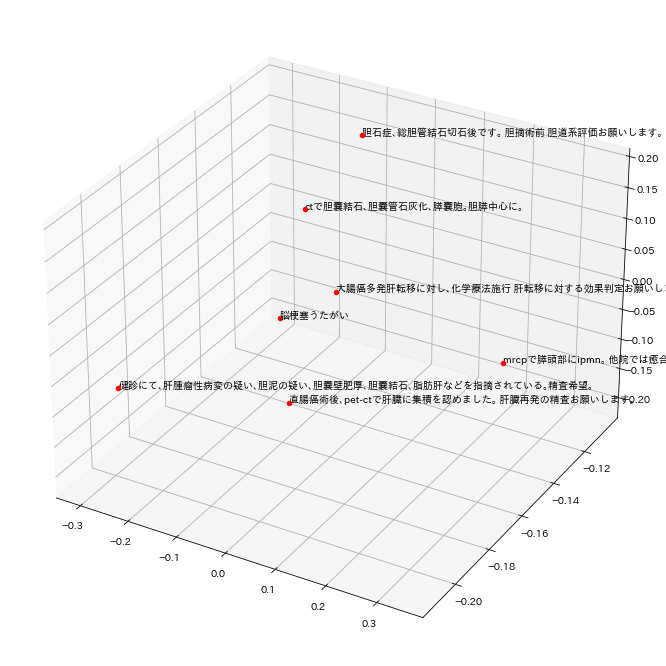

In [113]:
#三次元
fig = plt.figure(figsize=(20,12),facecolor='w')
ax = fig.add_subplot(projection='3d')

i = 0
while i < 7:
    #点プロット
    ax.text(data_pca[i][0], data_pca[i][1], data_pca[i][2], docs[i])
    #ax.scatter(x, y, z, color='green')
    ax.scatter(data_pca[i][0], data_pca[i][1], data_pca[i][2], docs[i], color='r')
 
    i += 1
#
#
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)
#ax.set_zlim(-2, 2)

plt.show()
fig.savefig('STR.png')

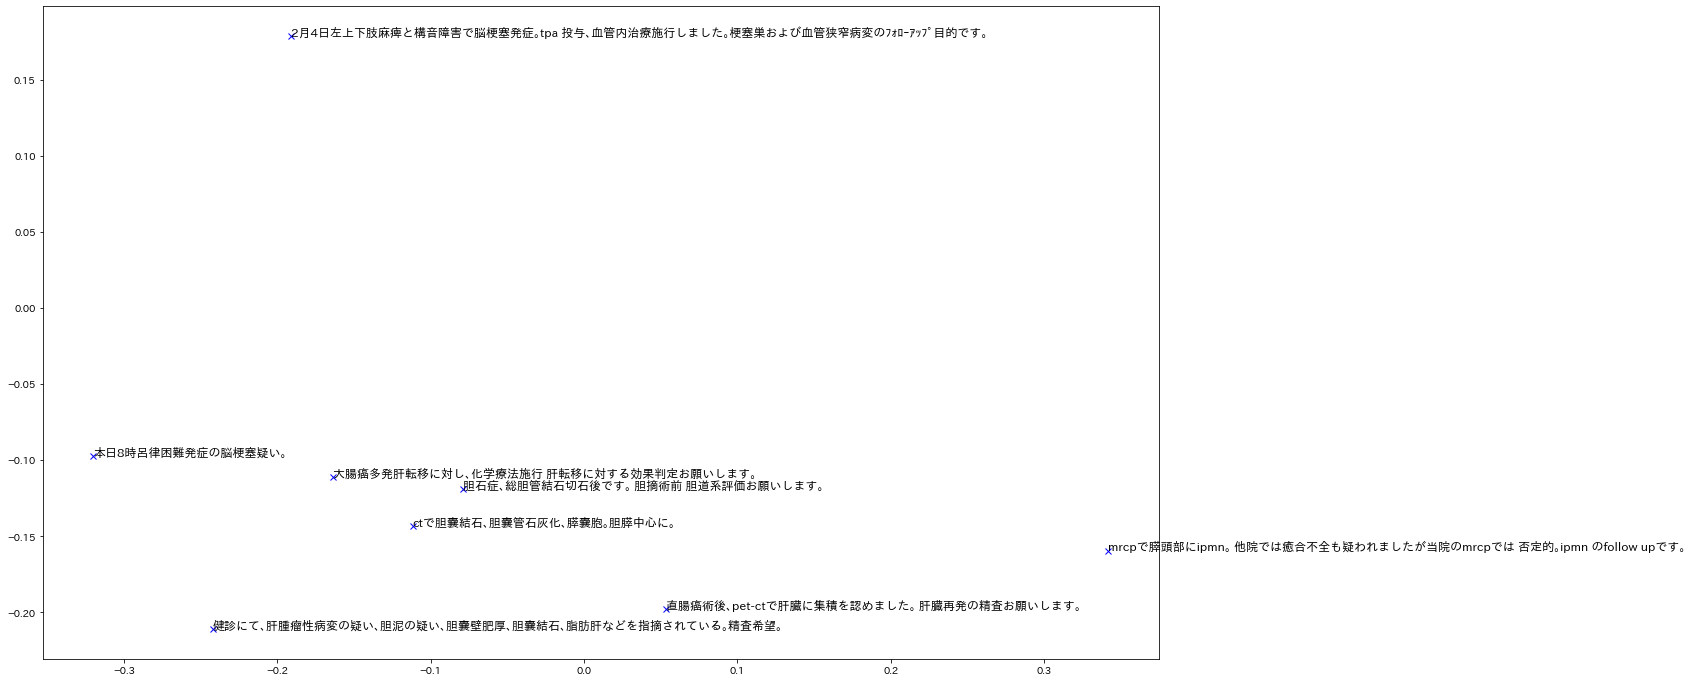

In [131]:
#2次元
fig=plt.figure(figsize=(20,12),facecolor='w')

plt.rcParams["font.size"] = 10
i = 0
while i < 8:
    #点プロット
    plt.plot(data_pca[i][0], data_pca[i][1], marker="x", color='b')
 
    #文字プロット
    plt.annotate(docs[i], (data_pca[i][0], data_pca[i][1]), size=12)
 
    i += 1

plt.show()
fig.savefig('STR.png')

In [1]:
#フォントファイルの置き場所
import matplotlib.font_manager as fm
fm.findSystemFonts()

['/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/ipaexg.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf']

In [2]:
import matplotlib
print(matplotlib.rcParams['font.family'])

['sans-serif']


In [3]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])

['STIXSizeTwoSym', 'STIXSizeOneSym', 'cmb10', 'STIXNonUnicode', 'cmex10', 'DejaVu Serif', 'cmss10', 'STIXGeneral', 'cmmi10', 'STIXSizeTwoSym', 'STIXGeneral', 'DejaVu Serif Display', 'DejaVu Sans Mono', 'DejaVu Sans', 'cmsy10', 'STIXGeneral', 'DejaVu Sans Mono', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXNonUnicode', 'STIXSizeThreeSym', 'cmr10', 'STIXSizeFourSym', 'STIXSizeThreeSym', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'STIXSizeFiveSym', 'STIXNonUnicode', 'DejaVu Sans', 'STIXSizeOneSym', 'cmtt10', 'DejaVu Sans', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans Mono', 'IPAexGothic', 'DejaVu Serif', 'DejaVu Sans']


In [4]:
import matplotlib
matplotlib.matplotlib_fname()

'/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

In [5]:
import matplotlib as mpl
mpl.get_configdir()

'/root/.config/matplotlib'

Text(0.5, 1.0, 'あんぎお')

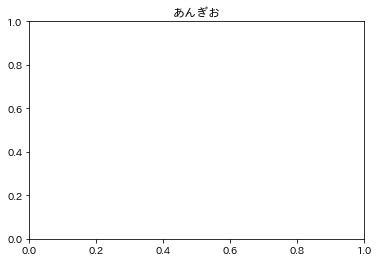

In [6]:
import matplotlib.pyplot as plt
plt.figure
mpl.rcParams['font.family'] = 'IPAexGothic'
plt.title('あんぎお')

In [ ]:
IPAexGothic